# ECSE 415 - Assignment 2
## Caelan Marks - 260744278

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

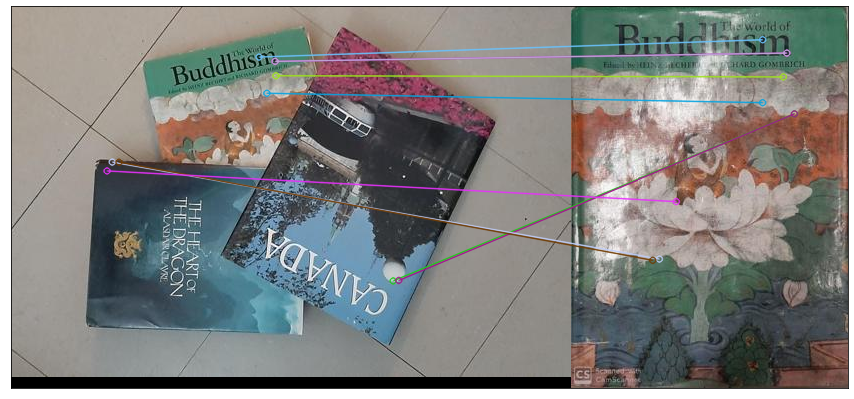

In [6]:
# load images
# img = cv2.imread("book.jpg")
img_occluded = cv2.imread("book_occlusion.jpg")
img_lighting = cv2.imread("book_crop.jpg")

img_occluded = cv2.cvtColor(img_occluded, cv2.COLOR_BGR2RGB)
img_lighting = cv2.cvtColor(img_lighting, cv2.COLOR_BGR2RGB)

# Create sift object
sift = cv2.xfeatures2d.SIFT_create()

# Get keypoints and descriptors
# original_keypoints, original_descriptors = sift.detectAndCompute(img, None)
occluded_keypoints, occluded_descriptors = sift.detectAndCompute(img_occluded, None)
lighting_keypoints, lighting_descriptors = sift.detectAndCompute(img_lighting, None)

# Match descriptors.
bf = cv2.BFMatcher()
matches = bf.match(occluded_descriptors, lighting_descriptors)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw the top 10 matches
matched_img = cv2.drawMatches(img_occluded,occluded_keypoints,img_lighting,lighting_keypoints, matches[:10], None, flags=2)

# Plot images
plt.figure(figsize=(15,15))
plt.imshow(matched_img)
plt.xticks([]), plt.yticks([])
plt.show()

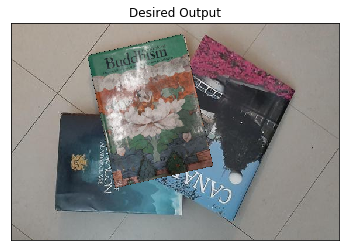

In [7]:
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    # Threshold matches that are above a certain distance
    if m.distance < 250:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mp_occluded = np.float32([occluded_keypoints[i].pt for (__, i) in GoodMatches])
mp_lighting = np.float32([lighting_keypoints[i].pt for (i, __) in GoodMatches])

# find homography using the RANSAC method
H, __ = cv2.findHomography(mp_lighting, mp_occluded, cv2.RANSAC, 4)

# warp image using transformation matrix
wimg = cv2.warpPerspective(img_lighting, H, (img_occluded.shape[1],img_occluded.shape[0]))

# created mask where the warped image is black then transfer pixels from the 
# coloured section of the warped image to the original image
ret, mask = cv2.threshold(wimg, 1, 255, cv2.THRESH_BINARY)
img_desired = img_occluded.copy()
img_desired[np.where(mask == 255)] = wimg[np.where(mask == 255)]

#Display image
plt.imshow(img_desired)
plt.title("Desired Output"), plt.xticks([]), plt.yticks([])
plt.show()